# Downloading gridMET data from the Northwest Knowledge Network THREDDS Data Server using Siphon and displaying it using CartoPy

#### 1. Import helpful libraries. We use Siphon here to easily connect and explore the TDS. We'll also need CartoPy to show the data spatially. Make sure to also install NetCDF4!

In [2]:
from siphon.catalog import TDSCatalog
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, date, timedelta
import numpy as np

#### 2. For making the map, we'll need a shapefile of state boundaries. You can grab this from lots of places and just stick it next to this notebook.

In [3]:
# Relative paths to shapefiles for your map, just replace these!
states_shape = 'shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp'

#### 3. Now we'll connect to the TDS and find our `.nc` files of interest. 
Specifically, we're interested in examing the Burning Index values for western Washington and Oregon for September 7-8, 2020. During this period, numerous large fires occurred due to high winds. Since winds are a primary component of the Burning Index, we expect very high values across much of the region. 

In [4]:
server = 'http://thredds.northwestknowledge.net:8080/thredds/catalog/MET/'
variable = 'bi'
endpoint = '/catalog.xml?dataset=REACCHDatasetScan_'

full_path = server + variable + endpoint + variable

# Establish a TDS instance (connection to the TDS)
server_conn = TDSCatalog(full_path)

# Display all of the datasets that are available for our query 
datasets = server_conn.datasets
print(datasets)

['bi_2020.nc', 'bi_2019.nc', 'bi_2018.nc', 'bi_2017.nc', 'bi_2016.nc', 'bi_2015.nc', 'bi_2014.nc', 'bi_2013.nc', 'bi_2012.nc', 'bi_2011.nc', 'bi_2010.nc', 'bi_2009.nc', 'bi_2008.nc', 'bi_2007.nc', 'bi_2006.nc', 'bi_2005.nc', 'bi_2004.nc', 'bi_2003.nc', 'bi_2002.nc', 'bi_2001.nc', 'bi_2000.nc', 'bi_1999.nc', 'bi_1998.nc', 'bi_1997.nc', 'bi_1996.nc', 'bi_1995.nc', 'bi_1994.nc', 'bi_1993.nc', 'bi_1992.nc', 'bi_1991.nc', 'bi_1990.nc', 'bi_1989.nc', 'bi_1988.nc', 'bi_1987.nc', 'bi_1986.nc', 'bi_1985.nc', 'bi_1984.nc', 'bi_1983.nc', 'bi_1982.nc', 'bi_1981.nc', 'bi_1980.nc', 'bi_1979.nc']


Since we know this event occurred in 2020, we'll select the `bi_2020.nc` file

In [5]:
dataset = datasets[0]

#### 4. Next, we'll formulate a query using the NetCDF subset service 
Here we set a bounding box roughly representing the Northwestern U.S. and provide a variable which to extract from the data

In [6]:
ncss = dataset.subset()
query = ncss.query()

In [7]:
bbox = [49.4000, 40.0666, -116, -126]
startdate = datetime(2020, 9, 7)
enddate = datetime(2020, 9, 7)
query.lonlat_box(north=bbox[0], south=bbox[1], east=bbox[2], 
                 west=bbox[3]).variables('burning_index_g').accept('netcdf').time_range(startdate, enddate)
data = ncss.get_data(query)

#### 5. With data in hand, we can extract all of the things we need to plot and make a pretty map. 

In [8]:
print(list(data.variables))

# Full extent of data
lats = data.variables['lat'][:].squeeze()
lons = data.variables['lon'][:].squeeze()
variable = data.variables['burning_index_g'][:].squeeze()

['burning_index_g', 'day', 'lat', 'lon']


#### 6. Now we can plot a figure with our data!
Note that this takes a while to create because the state boundaries are high resolution

Text(0.0, 1.0, 'Burning Index for 09/07/2020')

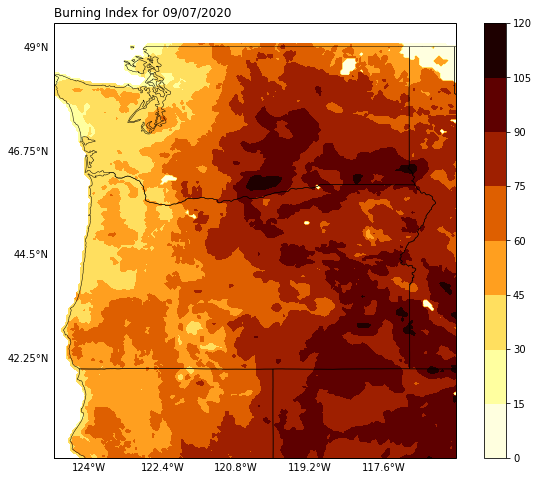

In [10]:
%matplotlib inline

# You might need to mess with the figsize or dpi to find an optimal aspect ratio
plt.figure(figsize=(10,8), frameon=False)

# Create a new map
ax = plt.axes(projection=ccrs.PlateCarree())

# Read in and add state boundaries
states = ShapelyFeature(Reader(states_shape).geometries(), ccrs.PlateCarree(), facecolor='none')
ax.add_feature(states, linewidth=.5, edgecolor="black")

# Use contourf to draw the data. Depending on your data, you may wish to play with the color map and levels
plt.contourf(lons, lats, variable, levels=9, transform=ccrs.PlateCarree(), cmap='afmhot_r')

# Add a colorbar
plt.colorbar()

# Add gridlines so we can label our axes. Set linewidth to 0 to keep it clean
# You may wish to change the linspace num (last value) for readability 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0,
                  xlocs=np.linspace(min(lons.astype(np.int64)), max(lons.astype(np.int64)), 6),
                  ylocs=np.linspace(min(lats.astype(np.int64)), max(lats.astype(np.int64)), 5))
# Tidy up labels
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add a title
plt.title('Burning Index for 09/07/2020', loc='left', fontsize='large', fontweight='medium')

As shown, Burning Index values for much of eastern Washington and Oregon were generally 75 to 120 If we consider that a value of 10 roughly translates to a 1-foot flame length, we see that flame lengths in these areas could have reached 7.5 to 12 feet! 